<a href="https://colab.research.google.com/github/danielad-k/SPRB/blob/master/Capstone%202/1.2%20Walmart%20Basic%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SUMMARY OF FINDINGS**

1. A simple one layer neuron network produced an accuracy of 77 - 79% 
2. In terms of preprocessing the following steps were taken:
  *   Fineline and UPC , only keep top 50% of most common values
  *   Convert all categorical variables into one hot encoding
  *   Group by Visit Number so each row is the sum of items    
    customers bought during a visit
  *   Transform using Robust Scaler    
  * Since we had many classes with imbalanced data use SMOTE to undersample the data


3. Model explainability showed that different features are important for different categories.

In [44]:
#!pip install shap


In [45]:
#!pip install imbalanced-learn

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import pickle
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, LSTM, Dense,Flatten,Dropout,TimeDistributed,LeakyReLU,Reshape
from tensorflow.keras import regularizers
import shap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
def cat_group(data,group_var = None,filter = None):
  if filter != None:
    exclusion = data.groupby(group_var).size().sort_values().reset_index().rename(columns = {0 : 'values'}).query("values <" + filter)[group_var].tolist()
    excl_data = data.query(group_var + " not in @exclusion").groupby(["VisitNumber","TripType",group_var]).size().reset_index().iloc[:,:-1]
    final = pd.get_dummies(excl_data)
    final_cols = final.columns.tolist()
    
  else:
    final = pd.get_dummies(data)
    final_cols = final.columns.tolist()
  
  final_dict = dict.fromkeys(final_cols[2:], "sum")
  return final.groupby(["TripType","VisitNumber"]).agg(final_dict).reset_index()

def create_norm_subplot_cat(dataframe,categorylist,category_name,figsize,numerical_value):
    fig = plt.figure(figsize = figsize)
    
    for c,num in zip(categorylist,range(1,len(categorylist))):
        """for each category group it by the main category and get the sum of the numerical_value column, get the percentages.
           and then select the main category with highest percentage
        """
        df0= dataframe[dataframe[category_name]==c]
        
        #add subplot
        ax = fig.add_subplot(10,5,num)
        #plot barplot with Spectral color palette
        ax = sns.barplot(x = numerical_value, y = 'feature_name', data = df0,palette =sns.color_palette("Spectral"))
        #add x-axi label
        ax.set(xlabel= numerical_value + '(%)')
        #plot title
        plt.title(c)

        plt.tight_layout()
    #Title for all plots
    #fig.suptitle('Top 5 Categories for Each Country for ' + numerical_value,fontsize = 15)
    #fig.subplots_adjust(top=1.5)


# **PROCESSING**

In [6]:
data = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/data_modeling.csv').iloc[:,1:]

In [7]:
data.loc[:,['Upc','FinelineNumber']] = data.loc[:,['Upc','FinelineNumber']].apply(lambda x: x.astype(str))


**Category Long to Wide**

In [8]:
Upc_final = cat_group(data.loc[:,["TripType","VisitNumber",'Upc']],'Upc','50')

In [9]:
fineline_final = cat_group(data.loc[:,["TripType","VisitNumber",'FinelineNumber']],'FinelineNumber','25')

In [10]:
other_final = cat_group(data.loc[:,["TripType","VisitNumber",'ScanCount','DepartmentDescription','COMMODITY','Return','Count_of_Item','Rename_Dep']],None,None)

**Merge Data Sources**

In [11]:
final_data = Upc_final.merge(fineline_final,on = ['TripType','VisitNumber']).merge(other_final,on = ['TripType','VisitNumber'])

In [12]:
final_data.head()

,TripType,VisitNumber,Upc_-999,Upc_1070002152,Upc_1070002440,Upc_1070070230,Upc_1070070259,Upc_1070070860,Upc_1070080722,Upc_1070080727,Upc_1090000015,Upc_1090000021,Upc_1090000114,Upc_1090008031,Upc_1099500870,Upc_1111104090,Upc_1111104094,Upc_1111161164,Upc_1111161424,Upc_1111587132,Upc_1112019909,Upc_1121701069,Upc_1200000017,Upc_1200000129,Upc_1200000131,Upc_1200000134,Upc_1200000159,Upc_1200000230,Upc_1200000452,Upc_1200001276,Upc_1200001311,Upc_1200011223,Upc_1200013027,Upc_1200013032,Upc_1200014143,Upc_1200080994,Upc_1200080995,Upc_1200080996,Upc_1200080997,Upc_1200081331,...,COMMODITY_PARSLEY,COMMODITY_PEACHES,COMMODITY_PEANUTS,COMMODITY_PEARS,COMMODITY_PEPPERS (CAPSICUMS),COMMODITY_PINEAPPLE,COMMODITY_PLUMS,COMMODITY_POTATO,COMMODITY_RADISH,COMMODITY_RUTABAGAS (SWEDE),COMMODITY_SQUASH,COMMODITY_SWEET POTATO/YAM/KUMARA,COMMODITY_TANGELO,COMMODITY_TANGERINES/MANDARINS,COMMODITY_TOMATOES,COMMODITY_TURNIP,COMMODITY_YUCA ROOT/CASSAVA/MANIOC,Return_Bought,Return_Returned,Count_of_Item_Multiple,Count_of_Item_Single,Rename_Dep_Auto,Rename_Dep_Baby,"Rename_Dep_Clothing,Shoes,and Accessories",Rename_Dep_Electronics,Rename_Dep_Financial Services,Rename_Dep_Food,Rename_Dep_Gifts and Crafts,Rename_Dep_Home Improvement and Patio,"Rename_Dep_Home,Furniture,and Appliances","Rename_Dep_Movies,Music,and Books",Rename_Dep_Office,Rename_Dep_Other,Rename_Dep_Pets,"Rename_Dep_Pharmacy,Health,and Beauty",Rename_Dep_Photo,Rename_Dep_Seasonal,Rename_Dep_Specialty Stores,Rename_Dep_Sports,Rename_Dep_Toys and Games
0,3,106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,162,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
final_data.loc[:,"TripType"] = final_data.loc[:,"TripType"].astype(str).astype('category')
final_data.loc[:,"TripT"] = final_data.loc[:,"TripType"].cat.codes

In [14]:
y = final_data.loc[:,"TripT"].values
y = y.reshape(-1,1)
X = final_data.drop(["TripT","TripType","VisitNumber"],axis = 1).values
#X = X.reshape(X.shape[0],1)

In [15]:
#print(Counter(pd.DataFrame(y_over)))
#print(Counter(pd.DataFrame(y)))
#len(y)
#len(y_over)

In [16]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [17]:
X_over, y_over = undersample.fit_resample(X, y)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


# **TRAIN TEST SPLIT**

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

In [19]:
from sklearn.preprocessing import RobustScaler
scaler =  RobustScaler(quantile_range = (35,75)).fit(X_train)
X_train_t = scaler.transform(X_train)
X_test_t = scaler.transform(X_test)

# **MODELING**

In [20]:
models = Sequential()
models.add(Dense(1000,activation = 'relu',kernel_regularizer=regularizers.l1(0.00001),input_dim = X_train_t.shape[1]))
models.add(Dropout(0.3))
#models.add(Flatten())
models.add(Dense(38, activation='softmax',kernel_regularizer=regularizers.l1(0.00001)))
#model.add((38, activation='softmax'))

In [21]:
models.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              4750000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                38038     
Total params: 4,788,038
Trainable params: 4,788,038
Non-trainable params: 0
_________________________________________________________________


In [22]:
models.compile(loss= 'sparse_categorical_crossentropy', 
              optimizer= 'adam', metrics=['accuracy']) 

#models.fit(X_train_t, y_train,validation_data = (X_test_t,y_test), epochs=45, verbose = 2, batch_size=256)

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [24]:
batch_size = 256
epochs = 17
hist = models.fit(X_train_t,y_train, batch_size=batch_size,epochs = epochs, validation_data = (X_test_t,y_test),verbose = 2, callbacks=[learning_rate_reduction])

Epoch 1/17
162/162 - 26s - loss: 1.6761 - accuracy: 0.6557 - val_loss: 1.1314 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 2/17
162/162 - 25s - loss: 1.0219 - accuracy: 0.7717 - val_loss: 1.0427 - val_accuracy: 0.7684 - lr: 0.0010
Epoch 3/17
162/162 - 26s - loss: 0.9301 - accuracy: 0.7989 - val_loss: 1.0210 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 4/17
162/162 - 27s - loss: 0.8784 - accuracy: 0.8175 - val_loss: 1.0163 - val_accuracy: 0.7747 - lr: 0.0010
Epoch 5/17
162/162 - 25s - loss: 0.8372 - accuracy: 0.8365 - val_loss: 1.0140 - val_accuracy: 0.7815 - lr: 0.0010
Epoch 6/17
162/162 - 26s - loss: 0.8023 - accuracy: 0.8526 - val_loss: 1.0094 - val_accuracy: 0.7821 - lr: 0.0010
Epoch 7/17
162/162 - 25s - loss: 0.7734 - accuracy: 0.8648 - val_loss: 1.0147 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 8/17
162/162 - 24s - loss: 0.7478 - accuracy: 0.8769 - val_loss: 1.0222 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 9/17
162/162 - 24s - loss: 0.7243 - accuracy: 0.8883 - val_loss: 1.0175 - val_accu

In [25]:
score = models.evaluate(X_test_t, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9809625744819641
Test accuracy: 0.7948668599128723


In [26]:
models.output.shape

TensorShape([None, 38])

# **MODEL EXPLAINABILITY: SHAP VALUES**

In [27]:
y_preds =models.predict(X_test_t, batch_size=264, verbose=1)
y_pred_bool = np.argmax(y_preds, axis=1)


40/40 [==============================] - 2s 50ms/step


# **CLASSIFICATION**

In [28]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})


In [29]:
print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.52      0.36      0.42        45
           2       0.61      0.50      0.55       135
           3       0.65      0.60      0.62        58
           4       0.50      0.39      0.44        18
           5       0.62      0.75      0.68        60
           6       0.76      0.68      0.72        69
           7       0.54      0.58      0.56        60
           8       0.00      0.00      0.00         5
           9       0.71      0.76      0.73       282
          10       0.77      0.79      0.78       375
          11       0.68      0.63      0.65        51
          12       0.70      0.73      0.71        73
          13       0.65      0.68      0.67        50
          14       0.64      0.42      0.51        43
          15       0.98      0.97      0.97       722
          16       0.52      0.55      0.53        86
          17       0.78      0.85      0.82        73
          18       0.75    

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [30]:
##class_report = pd.DataFrame(classification_report(y_test, y_pred_bool,output_dict = True)).unstack().reset_index().pivot_table(index=["level_0"],
                                                                                               #                 values=0, columns=["level_1"],fill_value=0).reset_index()

In [31]:
#There are a lot of misclassified '0'.
pd.DataFrame(confusion_matrix(y_test, y_pred_bool,normalize = 'true'))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
0,0.355556,0.111111,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.066667,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.022222,0.000000,0.022222,0.000000,0.088889,0.022222,0.0,0.000000,0.066667,0.022222,0.000000,0.022222,0.000000,0.022222,0.000000,0.044444,0.000000,0.022222,0.000000
1,0.044444,0.496296,0.007407,0.000000,0.000000,0.007407,0.007407,0.000000,0.007407,0.022222,0.000000,0.000000,0.007407,0.000000,0.000000,0.007407,0.007407,0.014815,0.014815,0.000000,0.081481,0.007407,0.029630,0.022222,0.0,0.000000,0.029630,0.000000,0.029630,0.007407,0.022222,0.000000,0.014815,0.037037,0.051852,0.022222,0.000000
2,0.000000,0.000000,0.603448,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.051724,0.000000,0.000000,0.068966,0.034483,0.000000,0.017241,0.0,0.000000,0.017241,0.000000,0.103448,0.000000,0.017241,0.000000,0.000000,0.000000,0.017241,0.017241,0.000000
3,0.000000,0.000000,0.000000,0.388889,0.000000,0.000000,0.277778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.055556,0.0,0.000000,0.000000,0.000000,0.055556,0.055556,0.055556,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000
4,0.000000,0.000000,0.016667,0.000000,0.750000,0.000000,0.016667,0.000000,0.016667,0.000000,0.016667,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.050000,0.0,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.016667,0.016667,0.033333,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.681159,0.014493,0.000000,0.014493,0.014493,0.000000,0.000000,0.000000,0.000000,0.014493,0.014493,0.000000,0.014493,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.0,0.000000,0.028986,0.000000,0.028986,0.101449,0.000000,0.000000,0.000000,0.000000,0.000000,0.028986,0.000000
6,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.583333,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.016667,0.016667,0.016667,0.033333,0.000000,0.016667,0.0,0.000000,0.033333,0.000000,0.066667,0.000000,0.000000,0.033333,0.000000,0.016667,0.000000,0.066667,0.016667
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000
8,0.000000,0.007092,0.003546,0.000000,0.000000,0.003546,0.000000,0.000000,0.755319,0.007092,0.003546,0.000000,0.000000,0.000000,0.003546,0.000000,0.000000,0.000000,0.017730,0.000000,0.003546,0.017730,0.007092,0.010638,0.0,0.000000,0.039007,0.007092,0.028369,0.028369,0.010638,0.014184,0.003546,0.007092,0.000000,0.017730,0.003546
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.786667,0.002667,0.000000,0.000000,0.000000,0.002667,0.018667,0.000000,0.002667,0.008000,0.005333,0.000000,0.013333,0.010667,0.010667,0.0,0.000000,0.016000,0.005333,0.045333,0.008000,0.024000,0.002667,0.002667,0.010667,0.000000,0.024000,0.000000


# **MODEL EXPLAINABILITY: FEATURE IMPORTANCE**

In [32]:
import shap
import math

## **Predicted Values**
Collect sample of observations where predicted value matches actual value

In [33]:
act =  pd.DataFrame({'actual':y_test.ravel(),'predicted':y_pred_bool}).query("predicted == actual").reset_index().groupby('actual',group_keys = False).apply(pd.DataFrame.sample, frac=.05)['index']

## **Shap Values**
Calculate shap values

In [34]:
explainer_shap_v = shap.DeepExplainer(models,X_test_t[act])

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


In [35]:
shap_values_v = explainer_shap_v.shap_values(X_test_t[act],ranked_outputs= True,check_additivity = False)

## **Shap Values Prob for Each Observation and Each Feature**

In [36]:
datf = []

In [37]:

for idx,val in enumerate(shap_values_v[0][0]):
  df =  pd.DataFrame({'index': idx,'values':val,'feature_name':final_data.drop(["TripT","TripType","VisitNumber"],axis = 1).columns})
  datf.append(df)

In [38]:
data_shap = pd.concat(datf)

In [39]:
#merge with predicted value
merge_final = data_shap.merge(pd.DataFrame({'predicted':shap_values_v[1].ravel()}).reset_index(),on = 'index')

In [40]:
#calculate probability
merge_final['prob'] = merge_final['values'].apply(lambda x: math.exp(x)).apply(lambda x: x/ (1 + x))

In [41]:
merge_final[['feature_name','predicted','prob']]

,feature_name,predicted,prob
0,Upc_-999,0,0.500329
1,Upc_1070002152,0,0.500000
2,Upc_1070002440,0,0.500000
3,Upc_1070070230,0,0.500000
4,Upc_1070070259,0,0.500000
...,...,...,...
1961332,Rename_Dep_Photo,37,0.500144
1961333,Rename_Dep_Seasonal,37,0.500000
1961334,Rename_Dep_Specialty Stores,37,0.500000
1961335,Rename_Dep_Sports,37,0.500398


## **Average Shap Value for Each Category**

In [42]:
pd.options.display.float_format = "{:,.7f}".format
fin = merge_final[['predicted','feature_name','prob']].groupby(['predicted','feature_name']).agg({'prob':'median'}).reset_index().sort_values(['prob'],ascending = False)

## **Plot Feature Importance for Each Category**

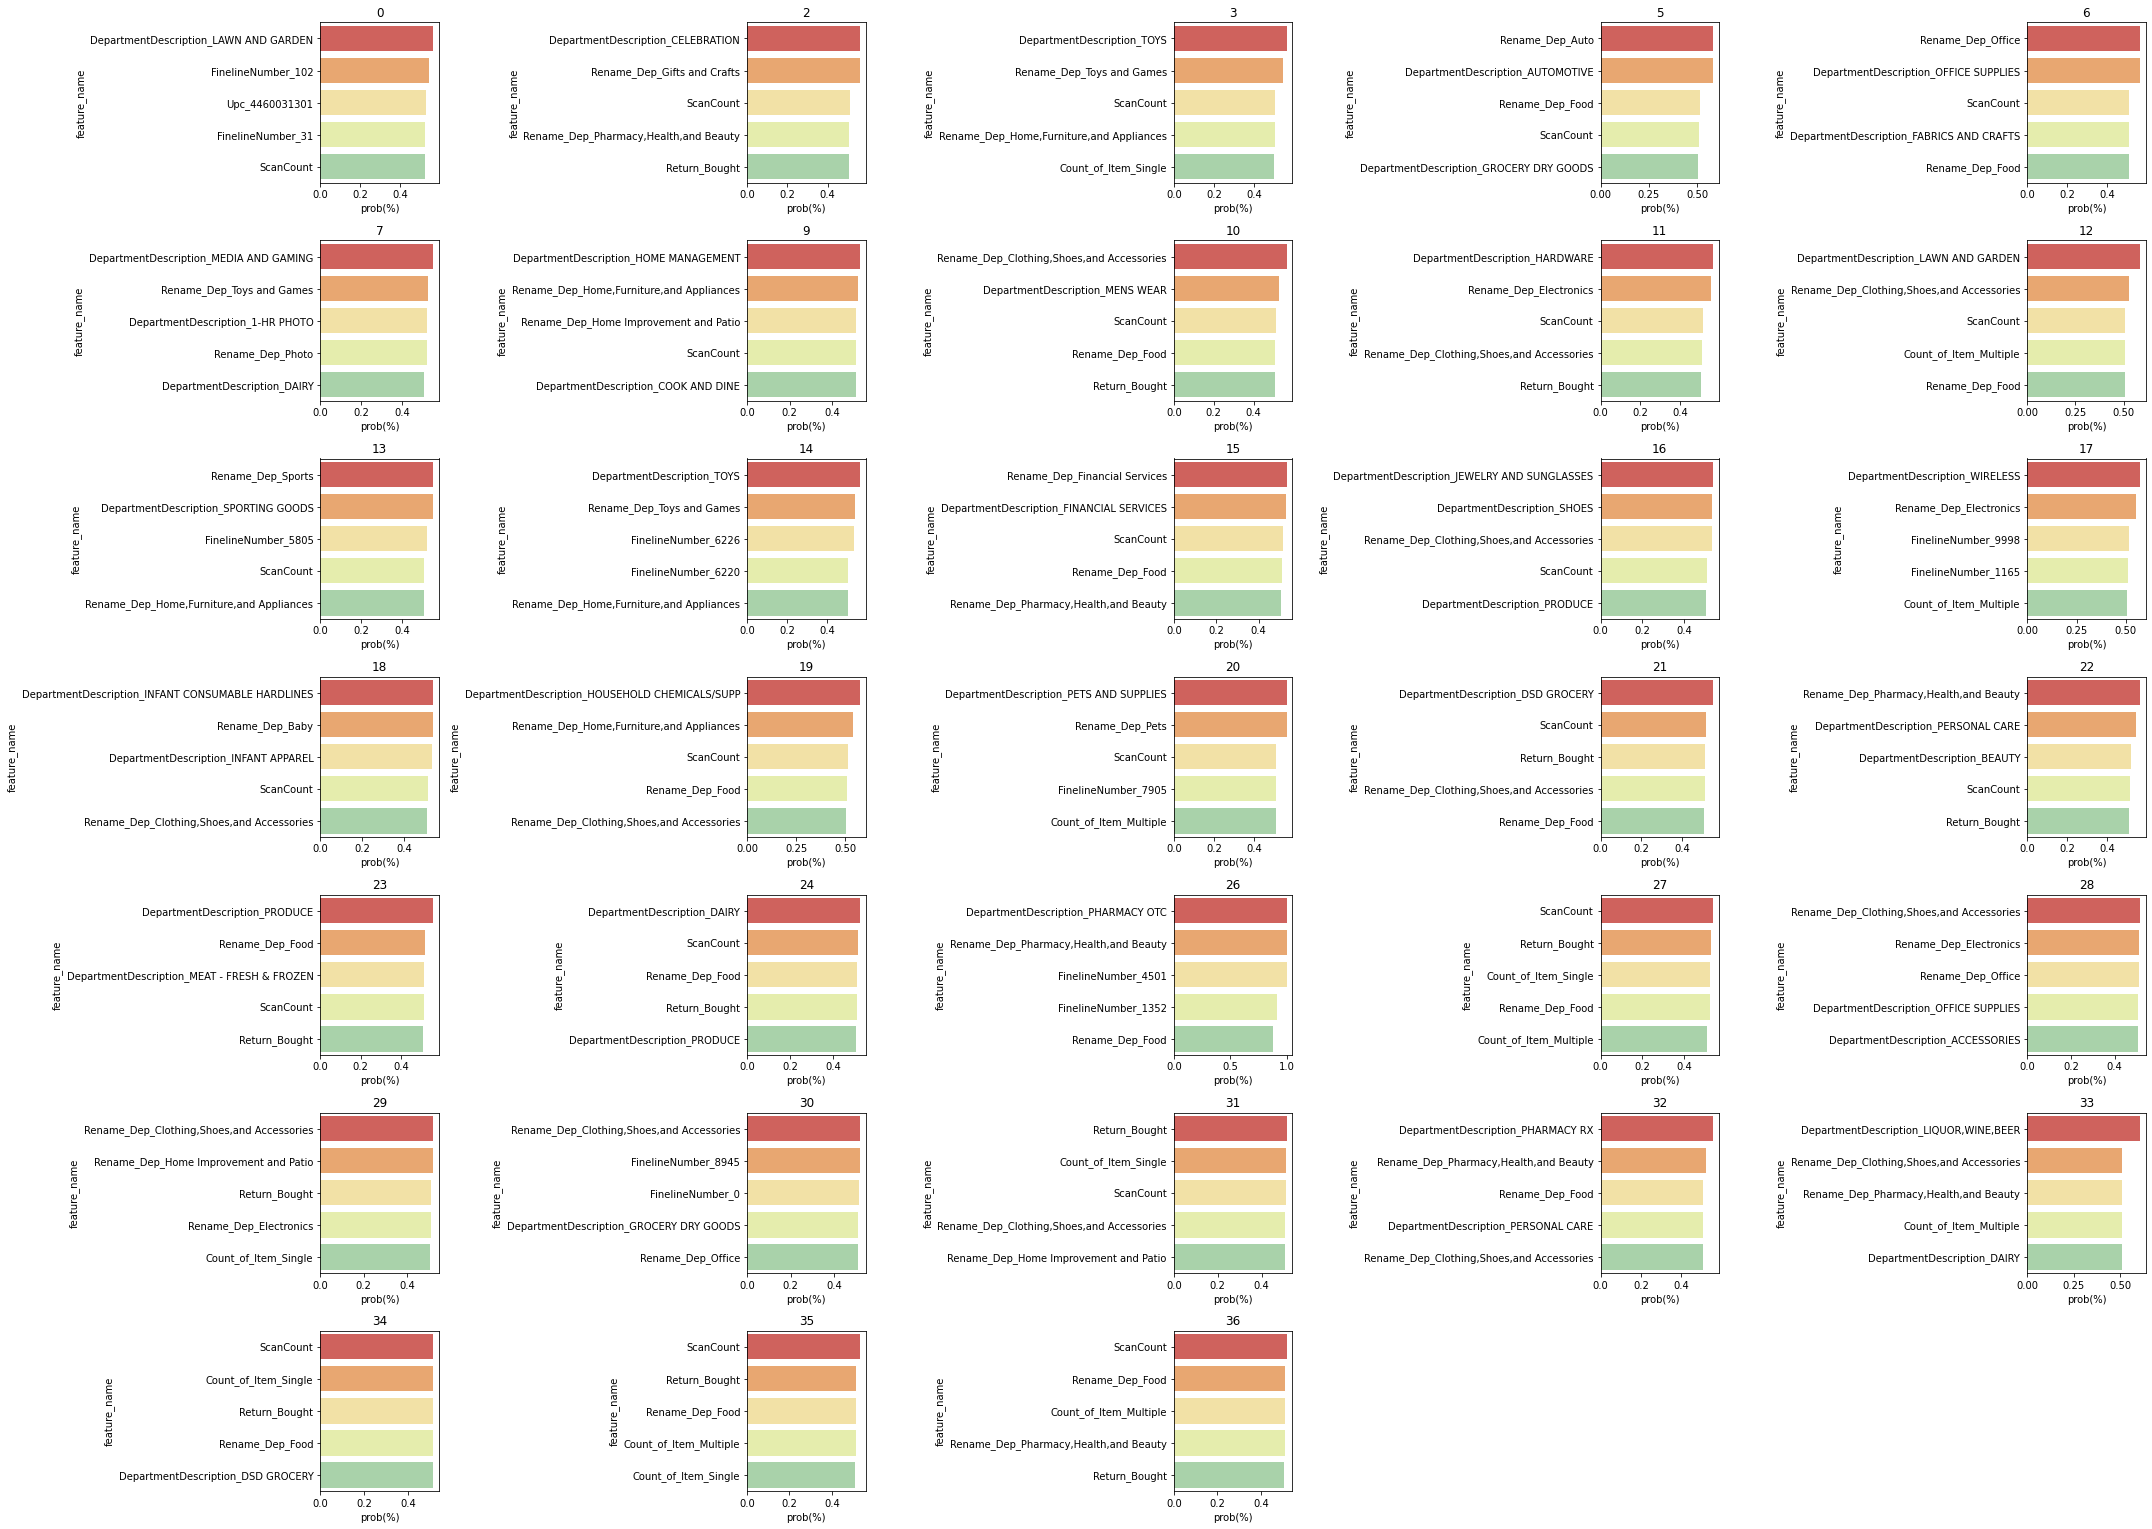

In [43]:

main_co = fin.groupby('predicted').head(5).predicted.unique().tolist()
create_norm_subplot_cat(fin.groupby('predicted').head(5),sorted(main_co),'predicted',(30,30),'prob')